In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


c:\Users\ebehnia\AppData\Local\anaconda3\conda-meta\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the dataset
file_path = 'Resources\historical-property-sales-data.csv'
data = pd.read_csv(file_path)

# Loading Load the dataset and initial cleaning

In [3]:
# Dropping Unnecessary columns that exist in the DataFrame
columns_to_drop = ['PropertyID', 'taxkey', 'Address', 'CondoProject']
existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=existing_columns_to_drop)

# Check columns after dropping
print('Columns after dropping unnecessary columns:', data.columns.tolist())

# Handling missing values by filling numeric columns with zeros and categorical columns with a placeholder
data.fillna({
    'Stories': 1,
}, inplace=True)

# Normalizing date formats
data['Sale_date'] = pd.to_datetime(data['Sale_date'], errors='coerce')

# Removing special characters and converting to numeric
data['Sale_price'] = data['Sale_price'].replace('[\\$,]', '', regex=True).astype(float)
data['FinishedSqft'] = data['FinishedSqft'].replace('[,]', '', regex=True).astype(float)
data['Lotsize'] = data['Lotsize'].replace('[,]', '', regex=True).astype(float)

# Converting appropriate columns to numeric types
numeric_columns = ['nbhd', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Check columns after conversion
print('Columns after conversion:', data.columns.tolist())

# Function to keep only 'Residential' in 'PropType'
def filter_residential(df):
    return df[df['PropType'] == 'Residential']

# Function to drop rows where 'Sale_price' is under 80,000
def drop_low_prices(df, threshold=80000):
    return df[df['Sale_price'] >= threshold]

# Apply the filtering functions
data = filter_residential(data)
data = drop_low_prices(data)

# Removing proptype since all should be residential now
data = data.drop(columns=['PropType'])

# Convert non-numeric columns to numeric using pd.get_dummies()
data = pd.get_dummies(data)

# Dropping any remaining rows with NaN values resulting from type conversion
cleaned_data = data.dropna()

# Displaying the cleaned dataset
print(cleaned_data.head())

Columns after dropping unnecessary columns: ['PropType', 'District', 'nbhd', 'Style', 'Extwall', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date', 'Sale_price']
Columns after conversion: ['PropType', 'District', 'nbhd', 'Style', 'Extwall', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date', 'Sale_price']
     District   nbhd  Stories  Year_Built  Rooms  FinishedSqft  Units  Bdrms  \
144       9.0  240.0      2.0      1948.0    7.0        2200.0      1    4.0   
179       5.0  800.0      1.0      1929.0    4.0        1125.0      1    2.0   
226       5.0  440.0      2.0      1979.0    8.0        2303.0      1    4.0   
235       5.0  800.0      2.0      1992.0    7.0        2428.0      1    3.0   
236       9.0  240.0      2.0      1862.0    5.0        1120.0      1    1.0   

     Fbath  Hbath  ...  Extwall_Frame Extwall_Masonary Frame  \
144    2.0    0.0  ...         

In [4]:


# Save the cleaned data to a new CSV file
cleaned_file_path = 'Resources\Cleanedd-historical-property-sales-data.csv'  # Adjust the path as needed
cleaned_data.to_csv(cleaned_file_path, index=False)


# Load the cleaned data and check columns

In [5]:
# Load the cleaned data for machine learning
cleaned_data = pd.read_csv(cleaned_file_path)

# Print the columns to check for the correct column names
print(cleaned_data.columns)


Index(['District', 'nbhd', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft',
       'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date',
       'Sale_price', 'Style_**', 'Style_AP 1', 'Style_Bi-Level',
       'Style_Cape Cod', 'Style_Colonial', 'Style_Contemporary',
       'Style_Cottage', 'Style_Dplx Bungalow', 'Style_Duplex N/S',
       'Style_Duplex O/S', 'Style_Duplex-Cottage', 'Style_Mansion',
       'Style_Milwaukee Bungalow', 'Style_Multiple Residential Bldgs',
       'Style_OBY', 'Style_Ranch', 'Style_Res O/S 1 Story',
       'Style_Res O/S 2sty +', 'Style_Res O/S A & 1/2', 'Style_Residence O/S',
       'Style_Residence O/S 2sty+', 'Style_Rm or Rooming House',
       'Style_Split Level', 'Style_Townhouse', 'Style_Triplex', 'Style_Tudor',
       'Extwall_Alum/Vynyl Siding', 'Extwall_Aluminum / Vinyl',
       'Extwall_Aluminum/Vinyl', 'Extwall_Asphalt/Other', 'Extwall_Block',
       'Extwall_Brick', 'Extwall_Fiber Cement/Hardiplank',
       'Extwall_Fiber-Cement', 'Extwall

# Cleaning column names

In [6]:
# Clean column names by stripping any extra spaces
cleaned_data.columns = cleaned_data.columns.str.strip()

# Check the cleaned column names
print(cleaned_data.columns)

Index(['District', 'nbhd', 'Stories', 'Year_Built', 'Rooms', 'FinishedSqft',
       'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date',
       'Sale_price', 'Style_**', 'Style_AP 1', 'Style_Bi-Level',
       'Style_Cape Cod', 'Style_Colonial', 'Style_Contemporary',
       'Style_Cottage', 'Style_Dplx Bungalow', 'Style_Duplex N/S',
       'Style_Duplex O/S', 'Style_Duplex-Cottage', 'Style_Mansion',
       'Style_Milwaukee Bungalow', 'Style_Multiple Residential Bldgs',
       'Style_OBY', 'Style_Ranch', 'Style_Res O/S 1 Story',
       'Style_Res O/S 2sty +', 'Style_Res O/S A & 1/2', 'Style_Residence O/S',
       'Style_Residence O/S 2sty+', 'Style_Rm or Rooming House',
       'Style_Split Level', 'Style_Townhouse', 'Style_Triplex', 'Style_Tudor',
       'Extwall_Alum/Vynyl Siding', 'Extwall_Aluminum / Vinyl',
       'Extwall_Aluminum/Vinyl', 'Extwall_Asphalt/Other', 'Extwall_Block',
       'Extwall_Brick', 'Extwall_Fiber Cement/Hardiplank',
       'Extwall_Fiber-Cement', 'Extwall

# Preparing the data for modeling

In [7]:
# Prepare the data for modeling
X = cleaned_data.drop(columns=['Sale_date', 'Sale_price'])
y = cleaned_data['Sale_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
#Initialize the linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)


LinearRegression()

In [9]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Handle zero or near-zero values in actual prices for MAPE calculation
y_test_non_zero = y_test.copy()
y_test_non_zero[y_test_non_zero == 0] = 1  # Replace zeros with ones to avoid division by zero

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test_non_zero)) * 100
print(f'Mean Absolute Percentage Error (corrected): {mape}%')

# Calculate the R-squared score
r2_score = model.score(X_test, y_test)
print(f'R-squared: {r2_score}')
print(f'R-squared as percentage: {r2_score * 100}%')

Mean Squared Error: 4125238318.019861
Mean Absolute Error: 44434.714279258675
Mean Absolute Percentage Error (corrected): 25.661590904576983%
R-squared: 0.5186184028964748
R-squared as percentage: 51.861840289647475%


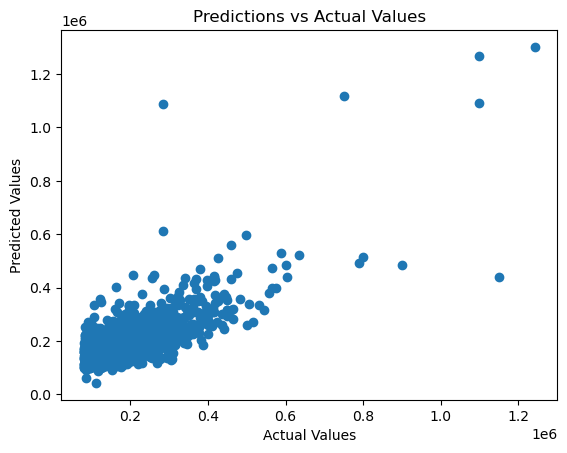

In [10]:
# Plot the predictions vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.show()



#  Train and evaluate an advanced model (Random Forest)

In [14]:
# Initializing the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculating Mean Squared Error (MSE) for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')

# Calculating Mean Absolute Error (MAE) for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Random Forest Mean Absolute Error: {mae_rf}')

# Calculation for the R-squared score for Random Forest
r2_score_rf = rf_model.score(X_test, y_test)
print(f'Random Forest R-squared: {r2_score_rf}')
print(f'Random Forest R-squared as percentage: {r2_score_rf * 100}%')


Random Forest Mean Squared Error: 2358130799.0078483
Random Forest Mean Absolute Error: 30655.78719457423
Random Forest R-squared: 0.7248254082081023
Random Forest R-squared as percentage: 72.48254082081023%
